---
tags:
- pytorch
- DL

include:
- math
---

# 快速入门

> [pytorch's tutorials for beginner](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html)

本文会涉及到一些机器学习的术语，例如`数据集`、`标签`、`模型`、`损失函数`等等。读者如果不熟悉可以问一问AI，我就不再解释了。

## 前置准备

我们首先需要学会正确安装pytorch：
![](../assets/2025-04-15-17-57-23.png)

- 如果你的操作系统是MacOS，那么比较简单
    - 直接`pip3 install torch`就可以了
    - pip会自动下载对应的版本，通常可以直接获得`mps`加速（Apple Metal）
- 如果你的操作系统是Windows，那么有两种情况
    - `pip3 install torch`会安装CPU支持的torch，没有显卡加速
    - `pip3 install torch --index-url https://download.pytorch.org/whl/cu118`会安装CUDA支持的torch，可以使用Nvidia CUDA加速计算
- 如果你的系统是Linux还可以安装AMD显卡驱动的ROCm版torch

### 导入torch

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

如果可以正常导入不报错，说明torch成功安装了。

这里我再额外引入两个库用来画图：

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 没安装的话直接运行：
# pip3 install matplotlib
# 就可以了

In [3]:
# 为了可以稳定复现训练结果，我们在这里设置一些种子
import random

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.mps.manual_seed(0)
torch.use_deterministic_algorithms(True)

### 使用mps加速

在MacOS平台，可以使用mps加速

In [4]:
# 检查mps加速是否可用
torch.backends.mps.is_available()

True

## 任务

[FashionMNIST](https://www.kaggle.com/datasets/zalando-research/fashionmnist)是一个很简单的图像数据集。它由70000万张分辨率为28*28的图片组成。每张图片中都有一件衣服，可能属于以下十个类别：

0. T-shirt/top
1. Trouser
2. Pullover
3. Dress
4. Coat
5. Sandal
6. Shirt
7. Sneaker
8. Bag
9. Ankle boot

我们的任务是在这个数据集上构造一个**分类模型**$f_\theta(x)$，它输入一张图像$x$，输出图像的标签$y$（图中的衣服是哪一类）。

### 数据集

torchvision提供了一些基本的数据集，我们可以很轻松引入。自然也包括了FashionMNIST

In [5]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

第一次运行会从网上下载FashionMNIST数据集，下载的文件如下：

In [6]:
!tree data

data
└── FashionMNIST
    └── raw
        ├── t10k-images-idx3-ubyte
        ├── t10k-images-idx3-ubyte.gz
        ├── t10k-labels-idx1-ubyte
        ├── t10k-labels-idx1-ubyte.gz
        ├── train-images-idx3-ubyte
        ├── train-images-idx3-ubyte.gz
        ├── train-labels-idx1-ubyte
        └── train-labels-idx1-ubyte.gz

3 directories, 8 files


### 数据集划分

训练集和测试集FashionMNIST已经为我们划分好了（按照6:1的比例）。

我们使用DataLoader来批量读取数据，这是为了后续的随机梯度下降优化算法做准备。

In [7]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28])
Shape of y: torch.Size([128]) torch.int64


`batch_size = 128`意味着，我们每步会拿出128张图片进行随机梯度下降。

### 数据展示

In [8]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

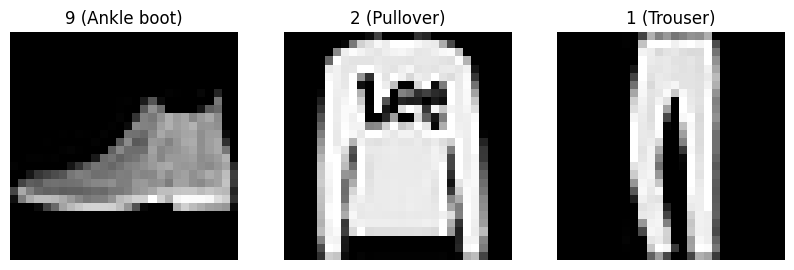

In [9]:
fig, ax = plt.subplots(1, 3, figsize = (10, 15))
for i in range(3):
    ax[i].imshow(X[i, 0,:].to('cpu').numpy(), cmap = 'gray')
    ax[i].set_title(f"{y[i].item()} ({classes[y[i].item()]})")
    ax[i].axis('off')

## 搭建模型

torch最大的优势就是可以模块化搭建各种模型，torch.nn提供了丰富的模块化操作。

### 模型架构

我们这里就是用最简单的全连接神经网络：

```text
Flatten->[ Linear + Relu ] * 2 -> Linear
```

图像输入之后，

1. 先使用Flatten操作把它展开为一维的向量（784维）。
2. 然后经过两个神经元（线性变换+Relu激活），数据在这里变为512维。
3. 最后通过一个线性层输出，数据从512维变为10维。

也就是说：
$$
f_\theta(x) = A_3(\mathrm{relu}(A_2(\mathrm{relu}(A_1(\mathrm{Flatten}(x)) +b_1))+b_2))+b_3
$$

其中可以优化的参数是一些矩阵和向量：
$$
\theta = \{ A_1,A_2,A_3,b_1,b_2,b_3 \}
$$

In [10]:
# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    # 模型前向计算的过程
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

### 模型实例

构造模型的实例，把权重文件保存在我们的mps显存里：

In [11]:
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")
model = NeuralNetwork().to(device)
print(model)

Using mps device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


## 优化模型

我们的任务是构造分类模型：
$$
\hat y = f_\theta(x)
$$

按照一些统计理论和经验法则，这个任务使用交叉熵作为损失函数是最合适的。

也就是说：

$$
\mathrm{loss} = \sum_i \mathrm{CE}(y_i, \hat y_i) = \sum_i\mathrm{CE}(y_i, f_\theta(x_i))
$$

我们的目标是寻找参数$\theta$最小化这个损失。

### 损失函数
torch自然也提供了交叉熵损失函数：

In [12]:
loss_fn = nn.CrossEntropyLoss()

### 优化算法
直接公式求解优化问题：
$$
\theta^* = \arg\min_{\theta\in\Theta} \sum_i\mathrm{CE}(y_i, f_\theta(x_i))
$$
是不现实的。我们考虑使用迭代优化算法SGD（Stochastic Gradient Descent）求解近似解。

在torch.optim中提供了各种优化器

In [13]:
# 我们把模型参数传入优化器即可：
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

## 模型训练和测试

### 训练

训练模型的过程就是不断把数据输入模型，计算损失：
```python
pred = model(X)
loss = loss_fn(pred, y)
```
然后计算梯度，沿着梯度迭代参数：
```python
loss.backward()
optimizer.step()
optimizer.zero_grad()
```

In [14]:
def train(dataloader, model, loss_fn, optimizer):
    model.train()
    train_loss = 0
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    train_loss /= num_batches
    return train_loss

### 测试
为了避免过拟合，我们使用模型在测试集上的表现来衡量模型的好坏。

In [15]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    return test_loss, correct

### 训练过程

In [16]:
epochs = 10
loss_log = []
for t in range(epochs):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, acc = test(test_dataloader, model, loss_fn)
    loss_log.append((train_loss, test_loss, acc))
    print(f"Epoch {t + 1} {train_loss=:.4f}, {test_loss=:.4f}, {acc=:.4f}")
print("Done!")

Epoch 1 train_loss=2.2704, test_loss=2.2364, acc=0.3085
Epoch 2 train_loss=2.1962, test_loss=2.1531, acc=0.4565
Epoch 3 train_loss=2.0954, test_loss=2.0333, acc=0.4894
Epoch 4 train_loss=1.9519, test_loss=1.8678, acc=0.5446
Epoch 5 train_loss=1.7689, test_loss=1.6755, acc=0.5758
Epoch 6 train_loss=1.5794, test_loss=1.4968, acc=0.6018
Epoch 7 train_loss=1.4156, test_loss=1.3509, acc=0.6228
Epoch 8 train_loss=1.2847, test_loss=1.2362, acc=0.6308
Epoch 9 train_loss=1.1817, test_loss=1.1458, acc=0.6395
Epoch 10 train_loss=1.1001, test_loss=1.0741, acc=0.6462
Done!


In [17]:
def plot(loss_log):
    train_loss, test_loss, acc = zip(*loss_log)
    plt.plot(train_loss, label='train_loss')
    plt.plot(test_loss, label='test_loss')
    plt.plot(acc, label='accuracy')
    plt.legend()
    plt.xlabel('epoch')
    plt.title('Loss and accuracy')

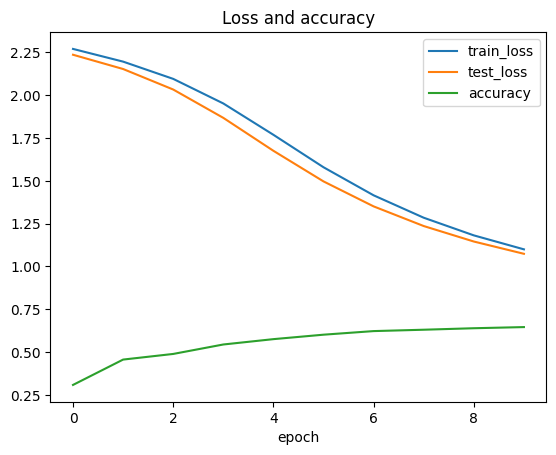

In [18]:
plot(loss_log)

可以看到，在我们训练的10轮里，损失下降的很快。模型还有很大的提高空间。

我们可以继续训练更多轮，并且增加早停条件来得到更好的模型：

In [19]:
max_epochs = 100
target = 0.01
prev = None
for t in range(max_epochs):
    train_loss = train(train_dataloader, model, loss_fn, optimizer)
    test_loss, acc = test(test_dataloader, model, loss_fn)
    if prev is None:
        prev = train_loss
    else:
        # train loss几乎不再下降了
        # 说明模型已经收敛了
        if abs(train_loss - prev) < target:
            print(f"Early stopping at epoch {t + 1}")
            break
        prev = train_loss
    loss_log.append((train_loss, test_loss, acc))
    print(f"Epoch {t + 11} {train_loss=:.4f}, {test_loss=:.4f}, {acc=:.4f}")
print("Done!")

Epoch 11 train_loss=1.0351, test_loss=1.0166, acc=0.6497
Epoch 12 train_loss=0.9825, test_loss=0.9700, acc=0.6565
Epoch 13 train_loss=0.9396, test_loss=0.9318, acc=0.6621
Epoch 14 train_loss=0.9041, test_loss=0.9000, acc=0.6687
Epoch 15 train_loss=0.8743, test_loss=0.8731, acc=0.6735
Epoch 16 train_loss=0.8489, test_loss=0.8500, acc=0.6788
Epoch 17 train_loss=0.8269, test_loss=0.8299, acc=0.6852
Epoch 18 train_loss=0.8078, test_loss=0.8123, acc=0.6906
Epoch 19 train_loss=0.7908, test_loss=0.7965, acc=0.6949
Epoch 20 train_loss=0.7755, test_loss=0.7823, acc=0.7006
Epoch 21 train_loss=0.7617, test_loss=0.7693, acc=0.7085
Epoch 22 train_loss=0.7489, test_loss=0.7572, acc=0.7145
Epoch 23 train_loss=0.7370, test_loss=0.7459, acc=0.7206
Epoch 24 train_loss=0.7259, test_loss=0.7353, acc=0.7257
Epoch 25 train_loss=0.7154, test_loss=0.7253, acc=0.7310
Early stopping at epoch 16
Done!


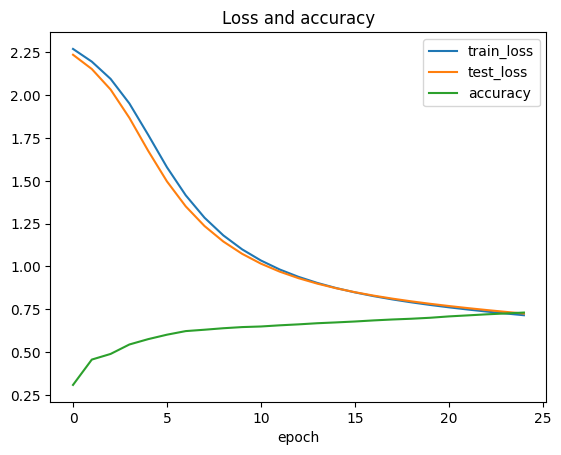

In [20]:
plot(loss_log)

## 模型推理

训练好的模型，可以用来预测它没见过的图片是哪个类别：

In [21]:
model.eval()
for i in range(15):
    x, y = test_data[i][0], test_data[i][1]
    with torch.no_grad():
        x = x.to(device)
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        wrong = predicted != actual
        print("❌" if wrong else "✅", f'Predicted: "{predicted}", Actual: "{actual}"')

✅ Predicted: "Ankle boot", Actual: "Ankle boot"
✅ Predicted: "Pullover", Actual: "Pullover"
✅ Predicted: "Trouser", Actual: "Trouser"
✅ Predicted: "Trouser", Actual: "Trouser"
✅ Predicted: "Shirt", Actual: "Shirt"
✅ Predicted: "Trouser", Actual: "Trouser"
✅ Predicted: "Coat", Actual: "Coat"
❌ Predicted: "Coat", Actual: "Shirt"
❌ Predicted: "Sneaker", Actual: "Sandal"
✅ Predicted: "Sneaker", Actual: "Sneaker"
✅ Predicted: "Coat", Actual: "Coat"
✅ Predicted: "Sandal", Actual: "Sandal"
❌ Predicted: "Sandal", Actual: "Sneaker"
✅ Predicted: "Dress", Actual: "Dress"
✅ Predicted: "Coat", Actual: "Coat"


### 模型的保存和读取

我们可以很轻松地保存模型的参数：

In [22]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


其他人拿到我们的模型权重文件，可以进行相应的读取：

In [23]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth", weights_only=True))

<All keys matched successfully>

> 为了保持git仓库清洁，我把训练过程中产生的文件ignore掉

In [24]:
!echo "model.pth\ndata" > .gitignore

恭喜你，你已经学会了AI的终极奥义，快去自己试试吧！